# 🇬🇧 UK Inter-Industry Economic Network Analysis (2022–2024)

### **Overview**
This notebook explores how £4 trillion flowed between UK industries from 2022 to 2024 using official ONS data.  
Through **network analysis**, I mapped how industries interact as a payment system — identifying which sectors drive, connect, and stabilize the economy.

Using Python, I built a **network graph**, computed **centrality measures** (inflow, outflow, betweenness, eigenvector), and grouped industries into clusters using **KMeans**.  
The findings reveal that while **Financial Hubs dominate systemic influence**, **Connector sectors** maintain resilience and prevent economic fragmentation.

---

### **Tools & Methods**
- **Python Libraries:** NetworkX, Pandas, Scikit-learn, Matplotlib, Seaborn  
- **Data Sources:** ONS official datasets  
- **Next Steps:**  
  Results were integrated into **SQL** and visualized in a **Power BI interactive dashboard** to uncover flow trends and network influence.

---

### **Data Sources**
- 📊 [ONS UK Industry-to-Industry Payment Flows (Jan 2017 – Nov 2024)](https://www.ons.gov.uk/economy/economicoutputandproductivity/output/datasets/industrytoindustrypaymentflowsukexperimentaldataandinsights)  
- 🗂️ [ONS UK SIC Structure Summary (1988–2025)](https://www.ons.gov.uk/methodology/classificationsandstandards/ukstandardindustrialclassificationofeconomicactivities/uksic2007)

---

*Developed by Mohd Nafees (2025)*  
*MSc Data Science – Birkbeck, University of London*

In [46]:
#Importing necceasry LIbrary

In [70]:
import sys
!{sys.executable} -m pip install networkx
!pip install networkx
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt




 ### Step 1 – Importing and Cleaning the Raw Excel Data

In [71]:

# File path
file_path = "ukindustrytoindustrypaymentflowsjanuary2017tonovember2024final.xlsx"

# Target sheets and expected columns
target_sheets = ["Table 6", "Table 7", "Table 8"]
expected_cols = [
    "Payer (2-digit SIC)", "Payee (2-digit SIC)", "Date",
    "Value (£)", "Number of transactions"
]

dfs = []

for sheet in target_sheets:
    print(f"\nReading {sheet} ...")
    
    # Read with header at row 8
    df = pd.read_excel(file_path, sheet_name=sheet, header=8)
    df["Source_Sheet"] = sheet

    # Standardize columns — only keep expected ones
    df = df[[c for c in df.columns if c in expected_cols] + ["Source_Sheet"]]
    
    # Drop rows that are completely empty
    df = df.dropna(subset=["Payer (2-digit SIC)", "Payee (2-digit SIC)", "Value (£)"], how="any")

    print(f"{sheet} rows after cleaning: {df.shape[0]}")
    print(f"Columns detected: {df.columns.tolist()}")
    dfs.append(df)

# Combine all sheets safely
combined_df = pd.concat(dfs, ignore_index=True)

# Rename columns
combined_df = combined_df.rename(columns={
    "Payer (2-digit SIC)": "Payer_SIC",
    "Payee (2-digit SIC)": "Payee_SIC",
    "Date": "Date",
    "Value (£)": "Value_GBP",
    "Number of transactions": "Transactions"
})

# Clean and convert numeric values
combined_df["Value_GBP"] = (
    combined_df["Value_GBP"].astype(str)
    .str.replace(",", "", regex=False)
    .replace(["[c]", "[-]"], None)
)
combined_df["Value_GBP"] = pd.to_numeric(combined_df["Value_GBP"], errors="coerce")

combined_df["Transactions"] = (
    combined_df["Transactions"].astype(str)
    .str.replace(",", "", regex=False)
    .replace(["[c]", "[-]"], None)
)
combined_df["Transactions"] = pd.to_numeric(combined_df["Transactions"], errors="coerce")

# Drop any missing key data
combined_df = combined_df.dropna(subset=["Payer_SIC", "Payee_SIC", "Value_GBP"])

# Final check
print(f"\n Final clean dataset: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
print(" Year-wise breakdown:")
print(combined_df["Source_Sheet"].value_counts())

# Save
combined_df.to_csv("industry_to_industry_2022_2024_clean.csv", index=False)
print("\n Saved as: industry_to_industry_2022_2024_clean.csv")

# Show preview
print("\n Sample data:")
print(combined_df.head(10))


Reading Table 6 ...
Table 6 rows after cleaning: 94140
Columns detected: ['Payer (2-digit SIC)', 'Payee (2-digit SIC)', 'Date', 'Value (£)', 'Number of transactions', 'Source_Sheet']

Reading Table 7 ...
Table 7 rows after cleaning: 94140
Columns detected: ['Payer (2-digit SIC)', 'Payee (2-digit SIC)', 'Date', 'Value (£)', 'Number of transactions', 'Source_Sheet']

Reading Table 8 ...
Table 8 rows after cleaning: 86295
Columns detected: ['Payer (2-digit SIC)', 'Payee (2-digit SIC)', 'Date', 'Value (£)', 'Number of transactions', 'Source_Sheet']

 Final clean dataset: 201614 rows, 6 columns
 Year-wise breakdown:
Source_Sheet
Table 7    68844
Table 6    68640
Table 8    64130
Name: count, dtype: int64

 Saved as: industry_to_industry_2022_2024_clean.csv

 Sample data:
   Payer_SIC  Payee_SIC            Date     Value_GBP  Transactions  \
0          0          0    January 2022  4.216921e+10     1677200.0   
1          0          0   February 2022  4.108873e+10     1700000.0   
2        

I imported payment data from three Excel sheets (Tables 6–8) covering 2022–2024.
After removing empty rows, fixing numeric formats, and renaming columns, all sheets were merged into one clean dataset with 201,614 records and 6 columns.
This combined file — industry_to_industry_2022_2024_clean.csv — is now ready for further network and clustering analysis.

### Step 2 – Checking Year-Wise Data Split

In [4]:
print("Unique years detected:", combined_df["Date"].apply(lambda x: str(x).split()[-1]).unique())
print("\nSample 2022 rows:")

print(combined_df[combined_df["Source_Sheet"] == "Table 6"].head(5))
print("\nSample 2023 rows:")
print(combined_df[combined_df["Source_Sheet"] == "Table 7"].head(5))

print("\nSample 2024 rows:")
print(combined_df[combined_df["Source_Sheet"] == "Table 8"].head(5))

Unique years detected: ['2022' '2023' '2024']

Sample 2022 rows:
   Payer_SIC  Payee_SIC           Date     Value_GBP  Transactions  \
0          0          0   January 2022  4.216921e+10     1677200.0   
1          0          0  February 2022  4.108873e+10     1700000.0   
2          0          0     March 2022  5.234422e+10     2001300.0   
3          0          0     April 2022  4.669162e+10     1759700.0   
4          0          0       May 2022  4.642707e+10     1919200.0   

  Source_Sheet  
0      Table 6  
1      Table 6  
2      Table 6  
3      Table 6  
4      Table 6  

Sample 2023 rows:
       Payer_SIC  Payee_SIC           Date     Value_GBP  Transactions  \
94140          0          0   January 2023  4.423414e+10     1774500.0   
94141          0          0  February 2023  4.205532e+10     1705000.0   
94142          0          0     March 2023  5.449720e+10     1976500.0   
94143          0          0     April 2023  4.659381e+10     1662700.0   
94144          0       

Here, I verified that each sheet corresponds to a different year of transactions.
By printing a few sample rows from each table, I confirmed that:
	•	Table 6 → 2022 data
	•	Table 7 → 2023 data
	•	Table 8 → 2024 data

This quick check ensured there were no overlaps or missing yearly entries before moving on to the mapping and analysis steps.

### Step 3 – Loading the SIC Industry Reference File

In [72]:


# Load your SIC reference file
sic_file = "publisheduksicsummaryofstructureworksheet.xlsx"

# Read the first sheet
sic_df = pd.read_excel(sic_file)

# Display first few rows to inspect structure
print("Preview of SIC reference data:")
print(sic_df.head(10))

# Try to identify columns that contain the code and description
potential_cols = sic_df.columns.tolist()
print("\n Columns in SIC file:", potential_cols)

Preview of SIC reference data:
                                         Description SECTION Division Group  \
0                  AGRICULTURE, FORESTRY AND FISHING       A       na    na   
1  Crop and animal production, hunting and relate...       A       01    na   
2                     Growing of non-perennial crops       A       01   011   
3  Growing of cereals (except rice), leguminous c...       A       01   011   
4                                    Growing of rice       A       01   011   
5  Growing of vegetables and melons, roots and tu...       A       01   011   
6                              Growing of sugar cane       A       01   011   
7                                 Growing of tobacco       A       01   011   
8                             Growing of fibre crops       A       01   011   
9               Growing of other non-perennial crops       A       01   011   

  Class Sub Class Most disaggregated level Level headings  
0    na        na                      

I imported the official UK SIC (Standard Industrial Classification) reference file to map numeric industry codes to their full descriptions.
By previewing the first few rows and listing all column names, I identified where the Division (2-digit SIC codes) and corresponding Industry descriptions were located.

This mapping step is important because it converts the coded payment data into meaningful industry names for better readability and analysis later.

### Step 4 – Mapping SIC Codes to Industry Names

In [73]:
# ===== 1 Extract only the Division-level SIC codes =====
sic_div = sic_df[sic_df["Level headings"].str.strip().str.lower() == "division"]

# Keep only Division code and description
sic_div = sic_div[["Division", "Description"]].dropna()
sic_div = sic_div.rename(columns={"Division": "SIC_Code", "Description": "Industry_Name"})

# Ensure codes are 2-digit strings
sic_div["SIC_Code"] = sic_div["SIC_Code"].astype(str).str.zfill(2)

print(f"Extracted {sic_div.shape[0]} SIC mappings.")
print(sic_div.head(10))

# ===== Step 3: Create a dictionary for mapping =====
sic_map = dict(zip(sic_div["SIC_Code"], sic_div["Industry_Name"]))

# Show a few mappings
print("\n Sample SIC Mappings:")
for k, v in list(sic_map.items())[:10]:
    print(f"{k} → {v}")

# ===== Step 4: Apply mapping to your main dataset =====

combined_df["Payer_Industry"] = combined_df["Payer_SIC"].astype(str).str.zfill(2).map(sic_map)
combined_df["Payee_Industry"] = combined_df["Payee_SIC"].astype(str).str.zfill(2).map(sic_map)

# ===== Step 5: Save enhanced dataset =====

# Replace NaN (unclassified code '00') with label
combined_df["Payer_Industry"] = combined_df["Payer_Industry"].fillna("Unclassified / Total")
combined_df["Payee_Industry"] = combined_df["Payee_Industry"].fillna("Unclassified / Total")

# Save again
combined_df.to_csv("industry_to_industry_2022_2024_with_industries.csv", index=False)
print("Updated and saved dataset with 'Unclassified / Total' labels.")


# ===== Step 6: Preview =====
print("\n Sample after adding industry names:")
print(combined_df[["Payer_SIC", "Payer_Industry", "Payee_SIC", "Payee_Industry", "Value_GBP", "Transactions", "Date"]].head(10))

Extracted 88 SIC mappings.
    SIC_Code                                      Industry_Name
1         01  Crop and animal production, hunting and relate...
42        02                               Forestry and logging
51        03                            Fishing and aquaculture
59        05                         Mining of coal and lignite
66        06      Extraction of crude petroleum and natural gas
71        07                               Mining of metal ores
77        08                         Other mining and quarrying
86        09                  Mining support service activities
92        10                       Manufacture of food products
136       11                           Manufacture of beverages

 Sample SIC Mappings:
01 → Crop and animal production, hunting and related service activities
02 → Forestry and logging
03 → Fishing and aquaculture
05 → Mining of coal and lignite
06 → Extraction of crude petroleum and natural gas
07 → Mining of metal ores
08 → Other

To make the dataset easier to interpret, I extracted only the Division-level SIC codes, which represent broader industry categories (e.g., “01 → Agriculture,” “10 → Food manufacturing”).

After cleaning and formatting these codes into a two-digit format, I created a dictionary to map each numeric SIC code to its corresponding industry name.
This mapping was then applied to both the Payer and Payee columns in the main dataset.

Finally, any missing or undefined entries (like “00”) were labeled as “Unclassified / Total.”
This step made the dataset fully human-readable, allowing me to see which industries were sending or receiving payments.

### Step 5 – Loading and Inspecting the Enhanced Dataset

In [74]:

# Load dataset
df = pd.read_csv("industry_to_industry_2022_2024_with_industries.csv")

# Show structure and sample
print(" Data loaded successfully.")
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nSample Data:\n", df.head(5))

 Data loaded successfully.
Shape: (201614, 8)

Columns: ['Payer_SIC', 'Payee_SIC', 'Date', 'Value_GBP', 'Transactions', 'Source_Sheet', 'Payer_Industry', 'Payee_Industry']

Data Types:
 Payer_SIC           int64
Payee_SIC           int64
Date               object
Value_GBP         float64
Transactions      float64
Source_Sheet       object
Payer_Industry     object
Payee_Industry     object
dtype: object

Sample Data:
    Payer_SIC  Payee_SIC           Date     Value_GBP  Transactions  \
0          0          0   January 2022  4.216921e+10     1677200.0   
1          0          0  February 2022  4.108873e+10     1700000.0   
2          0          0     March 2022  5.234422e+10     2001300.0   
3          0          0     April 2022  4.669162e+10     1759700.0   
4          0          0       May 2022  4.642707e+10     1919200.0   

  Source_Sheet        Payer_Industry        Payee_Industry  
0      Table 6  Unclassified / Total  Unclassified / Total  
1      Table 6  Unclassified / Tot

After mapping all SIC codes to their industry names, I reloaded the updated CSV file to verify that everything was saved correctly.

Here, I checked:
	•	The shape of the dataset (number of rows and columns).
	•	The data types of each column to ensure proper formatting.
	•	A quick sample of the first few rows to confirm that both Payer_Industry and Payee_Industry were properly labeled with readable names instead of numeric SIC codes.

This verification confirmed that the data was clean, consistent, and ready for the next stage of analysis.

In [75]:
# checking the null values 
df.isna().sum()

Payer_SIC         0
Payee_SIC         0
Date              0
Value_GBP         0
Transactions      0
Source_Sheet      0
Payer_Industry    0
Payee_Industry    0
dtype: int64

In [76]:
#checking the duplicated value
df.duplicated().sum()

np.int64(0)

###  Step 6 – Removing Unclassified Industry Records

In [77]:
mask = (df["Payer_Industry"] == "Unclassified / Total") | (df["Payee_Industry"] == "Unclassified / Total")
removed = df[mask].shape[0]
df = df[~mask]

print(f"Removed {removed:,} 'Unclassified / Total' records.")
print(f"Remaining valid industry-to-industry records: {df.shape[0]:,}")

Removed 6,136 'Unclassified / Total' records.
Remaining valid industry-to-industry records: 195,478


In this step, I cleaned the dataset further by removing all rows where either the payer or payee industry was labeled as “Unclassified / Total.”
These entries usually represent aggregated or incomplete data that don’t reflect specific industry-to-industry transactions.

After filtering them out, I printed how many such records were removed and confirmed how many valid payment relationships remained.

This ensures that the analysis focuses only on meaningful and clearly defined industry interactions, improving the quality and reliability of the insights generated later.

In [78]:
#print unique industries
print("Unique Industries:", df["Payer_Industry"].nunique())
print("\nSample industries:")
print(df["Payer_Industry"].unique()[:10])

Unique Industries: 88

Sample industries:
['Crop and animal production, hunting and related service activities'
 'Forestry and logging' 'Fishing and aquaculture'
 'Mining of coal and lignite'
 'Extraction of crude petroleum and natural gas' 'Mining of metal ores'
 'Other mining and quarrying' 'Mining support service activities'
 'Manufacture of food products' 'Manufacture of beverages']


In [79]:
#sanity check

df["Year"] = df["Date"].str.extract(r"(\d{4})").astype(int)
print(df["Year"].value_counts().sort_index())

Year
2022    66540
2023    66744
2024    62194
Name: count, dtype: int64


In [80]:
# Convert Date column to datetime (format like "January 2022")
df["Date"] = pd.to_datetime(df["Date"], format="%B %Y")

# Convert some object columns to category for efficiency
df["Source_Sheet"] = df["Source_Sheet"].astype("category")
df["Payer_Industry"] = df["Payer_Industry"].astype("category")
df["Payee_Industry"] = df["Payee_Industry"].astype("category")

# Verify
print(df.dtypes)

Payer_SIC                  int64
Payee_SIC                  int64
Date              datetime64[ns]
Value_GBP                float64
Transactions             float64
Source_Sheet            category
Payer_Industry          category
Payee_Industry          category
Year                       int64
dtype: object


In [81]:
df.to_csv("industry_transactions_final_typed.csv", index=False)
print("Final dataset saved as: industry_transactions_final_typed.csv")

Final dataset saved as: industry_transactions_final_typed.csv


In [82]:
pd.read_csv("industry_transactions_final_typed.csv")

,Payer_SIC,Payee_SIC,Date,Value_GBP,Transactions,Source_Sheet,Payer_Industry,Payee_Industry,Year
0,1,1,2022-01-01,47094000.0,4400.0,Table 6,"Crop and animal production, hunting and relate...","Crop and animal production, hunting and relate...",2022
1,1,1,2022-02-01,45685000.0,4200.0,Table 6,"Crop and animal production, hunting and relate...","Crop and animal production, hunting and relate...",2022
2,1,1,2022-03-01,60466000.0,5400.0,Table 6,"Crop and animal production, hunting and relate...","Crop and animal production, hunting and relate...",2022
3,1,1,2022-04-01,70301000.0,5400.0,Table 6,"Crop and animal production, hunting and relate...","Crop and animal production, hunting and relate...",2022
4,1,1,2022-05-01,77201000.0,5800.0,Table 6,"Crop and animal production, hunting and relate...","Crop and animal production, hunting and relate...",2022
...,...,...,...,...,...,...,...,...,...
195473,99,84,2024-07-01,977000.0,200.0,Table 8,Activities of extraterritorial organisations a...,Public administration and defence; compulsory ...,2024
195474,99,84,2024-08-01,1216000.0,200.0,Table 8,Activities of extraterritorial organisations a...,Public administration and defence; compulsory ...,2024
195475,99,84,2024-09-01,632000.0,100.0,Table 8,Activities of extraterritorial organisations a...,Public administration and defence; compulsory ...,2024
195476,99,84,2024-10-01,655000.0,100.0,Table 8,Activities of extraterritorial organisations a...,Public administration and defence; compulsory ...,2024


In [83]:

# File paths
DATA_FILE = "industry_transactions_final_typed.csv"   # path to your cleaned dataset
OUT_CENTRALITY_CSV = "industry_centrality_core_metrics.csv"
OUT_GRAPH_GRAPHML = "industry_payment_network.graphml"

In [84]:
# === Snippet 2: Load dataset and check basic structure ===
df = pd.read_csv(DATA_FILE, parse_dates=["Date"])

print("Data loaded successfully!")
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nSample rows:")
print(df.head(3))

Data loaded successfully!
Shape: (195478, 9)

Columns: ['Payer_SIC', 'Payee_SIC', 'Date', 'Value_GBP', 'Transactions', 'Source_Sheet', 'Payer_Industry', 'Payee_Industry', 'Year']

Data Types:
 Payer_SIC                  int64
Payee_SIC                  int64
Date              datetime64[ns]
Value_GBP                float64
Transactions             float64
Source_Sheet              object
Payer_Industry            object
Payee_Industry            object
Year                       int64
dtype: object

Sample rows:
   Payer_SIC  Payee_SIC       Date   Value_GBP  Transactions Source_Sheet  \
0          1          1 2022-01-01  47094000.0        4400.0      Table 6   
1          1          1 2022-02-01  45685000.0        4200.0      Table 6   
2          1          1 2022-03-01  60466000.0        5400.0      Table 6   

                                      Payer_Industry  \
0  Crop and animal production, hunting and relate...   
1  Crop and animal production, hunting and relate...   
2  Cr

### Step 7 – Aggregating Industry-to-Industry Payments

In [85]:
# ===  Aggregate payments between industries ===

def aggregate_edges(df, start_year=2022, end_year=2024, by="Value_GBP"):
    """Sum transaction value between each Payer–Payee pair within selected years."""
    df["Year"] = df["Date"].dt.year
    mask = (df["Year"] >= start_year) & (df["Year"] <= end_year)
    filtered = df.loc[mask]
    
    aggregated = (
        filtered.groupby(["Payer_Industry", "Payee_Industry"], as_index=False)
                .agg({by: "sum"})
                .rename(columns={by: "Total_Value_GBP"})
    )
    
    print(f"Aggregated {aggregated.shape[0]} unique industry connections "
          f"from {start_year} to {end_year}.")
    return aggregated

# Run aggregation
edges_df = aggregate_edges(df)
edges_df.head(5)

Aggregated 6034 unique industry connections from 2022 to 2024.


,Payer_Industry,Payee_Industry,Total_Value_GBP
0,Accommodation,Accommodation,2.312036e+09
1,Accommodation,Activities auxiliary to financial services and...,1.053790e+08
2,Accommodation,Activities of head offices; management consult...,9.014300e+08
3,Accommodation,Activities of households as employers of domes...,5.540000e+05
4,Accommodation,Activities of membership organisations,1.136540e+08



At this stage, I summarized all the transaction data to understand how money flows between industries.

Using the function aggregate_edges(), I grouped the dataset by Payer_Industry and Payee_Industry, then summed up all payments (in pounds) that occurred between 2022 and 2024.

This process helped transform the raw transaction-level data into a network-like structure, where each record now represents a connection (or edge) between two industries — showing the total payment value exchanged.

The result gives a clearer view of the financial relationships between different sectors, making it easier to visualize and analyze how industries depend on each other economically.

## Step 8 Build a directed weighted graph

In [86]:
# ===  Build a directed weighted graph ===

def build_industry_graph(edge_df):
    """
    Build a directed, weighted network of industry payment flows.

    Each node = an industry
    Each directed edge = total payments from payer → payee
    Weight = total £ value transferred between those industries
    """

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges (only for positive transaction values)
    for _, row in edge_df.iterrows():
        payer = row["Payer_Industry"]
        payee = row["Payee_Industry"]
        value = row["Total_Value_GBP"]

        if value > 0 and pd.notna(payer) and pd.notna(payee):
            G.add_edge(payer, payee, weight=value)

    print(f" Graph created successfully!")
    print(f"Nodes (industries): {G.number_of_nodes()}")
    print(f"Edges (connections): {G.number_of_edges()}")
    print(f"Total £ flow in network: {edge_df['Total_Value_GBP'].sum():,.0f}")

    return G


# --- Build the graph ---
G = build_industry_graph(edges_df)

 Graph created successfully!
Nodes (industries): 88
Edges (connections): 6034
Total £ flow in network: 3,984,907,298,000


## Step 9 Compute Key Centrality Metrics

In [87]:
# === Compute Key Centrality Metrics ===

def compute_centrality_measures(G):
    """
    Compute economically relevant centrality measures on the UK industry payment network.
    Includes:
        - Inflow (£)
        - Outflow (£)
        - Total Flow (£)
        - Betweenness Centrality
        - Eigenvector Centrality
    """

    print("🔍 Calculating centrality measures...")

    # Weighted Inflow and Outflow (sum of payments)
    inflow = dict(G.in_degree(weight="weight"))
    outflow = dict(G.out_degree(weight="weight"))

    # Total Flow = In + Out
    total_flow = {n: inflow.get(n, 0) + outflow.get(n, 0) for n in G.nodes()}

    # Betweenness (how much each node acts as a bridge)
    betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)

    # Eigenvector (influence across the whole network)
    try:
        eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=500)
    except nx.PowerIterationFailedConvergence:
        eigenvector = {n: None for n in G.nodes()}
        print(" Eigenvector centrality did not converge — skipped.")

    # Combine into DataFrame
    centrality_df = pd.DataFrame({
        "Industry": list(G.nodes()),
        "Inflow_GBP": [inflow[i] for i in G.nodes()],
        "Outflow_GBP": [outflow[i] for i in G.nodes()],
        "Total_Flow_GBP": [total_flow[i] for i in G.nodes()],
        "Betweenness": [betweenness[i] for i in G.nodes()],
        "Eigenvector": [eigenvector.get(i, None) for i in G.nodes()]
    })

    # Sort by Total Flow to see top players
    centrality_df = centrality_df.sort_values("Total_Flow_GBP", ascending=False).reset_index(drop=True)

    print("Centrality measures calculated successfully!")
    print(f"Top 5 industries by total payment activity:\n")
    print(centrality_df.head(5))

    return centrality_df


# --- Run the function ---
centrality_df = compute_centrality_measures(G)


🔍 Calculating centrality measures...
Centrality measures calculated successfully!
Top 5 industries by total payment activity:

                                            Industry    Inflow_GBP  \
0  Financial service activities, except insurance...  3.706949e+11   
1  Public administration and defence; compulsory ...  2.392231e+11   
2  Retail trade, except of motor vehicles and mot...  2.356373e+11   
3  Wholesale trade, except of motor vehicles and ...  3.326174e+11   
4  Office administrative, office support and othe...  2.402823e+11   

    Outflow_GBP  Total_Flow_GBP  Betweenness  Eigenvector  
0  4.650381e+11    8.357329e+11     0.000000     0.546227  
1  4.142461e+11    6.534691e+11     0.000000     0.224670  
2  3.468783e+11    5.825156e+11     0.011494     0.317892  
3  2.444548e+11    5.770723e+11     0.000000     0.424453  
4  2.839103e+11    5.241926e+11     0.000000     0.248636  


In [88]:

centrality_df


,Industry,Inflow_GBP,Outflow_GBP,Total_Flow_GBP,Betweenness,Eigenvector
0,"Financial service activities, except insurance...",3.706949e+11,4.650381e+11,8.357329e+11,0.000000,5.462274e-01
1,Public administration and defence; compulsory ...,2.392231e+11,4.142461e+11,6.534691e+11,0.000000,2.246703e-01
2,"Retail trade, except of motor vehicles and mot...",2.356373e+11,3.468783e+11,5.825156e+11,0.011494,3.178917e-01
3,"Wholesale trade, except of motor vehicles and ...",3.326174e+11,2.444548e+11,5.770723e+11,0.000000,4.244530e-01
4,"Office administrative, office support and othe...",2.402823e+11,2.839103e+11,5.241926e+11,0.000000,2.486364e-01
...,...,...,...,...,...,...
83,Manufacture of leather and related products,9.994740e+08,5.304860e+08,1.529960e+09,0.080059,1.138946e-03
84,Activities of extraterritorial organisations a...,1.175900e+08,1.456680e+08,2.632580e+08,0.233494,1.549788e-04
85,Activities of households as employers of domes...,4.728300e+07,4.419900e+07,9.148200e+07,0.390938,4.379886e-05
86,Mining of metal ores,0.000000e+00,6.431000e+06,6.431000e+06,0.000000,3.436376e-159


## Step 10 Normalizing Centrality Metrics

⚙️ Scaling centrality measures to 1–100 range
 Normalization complete. Values scaled between 1 and 100.


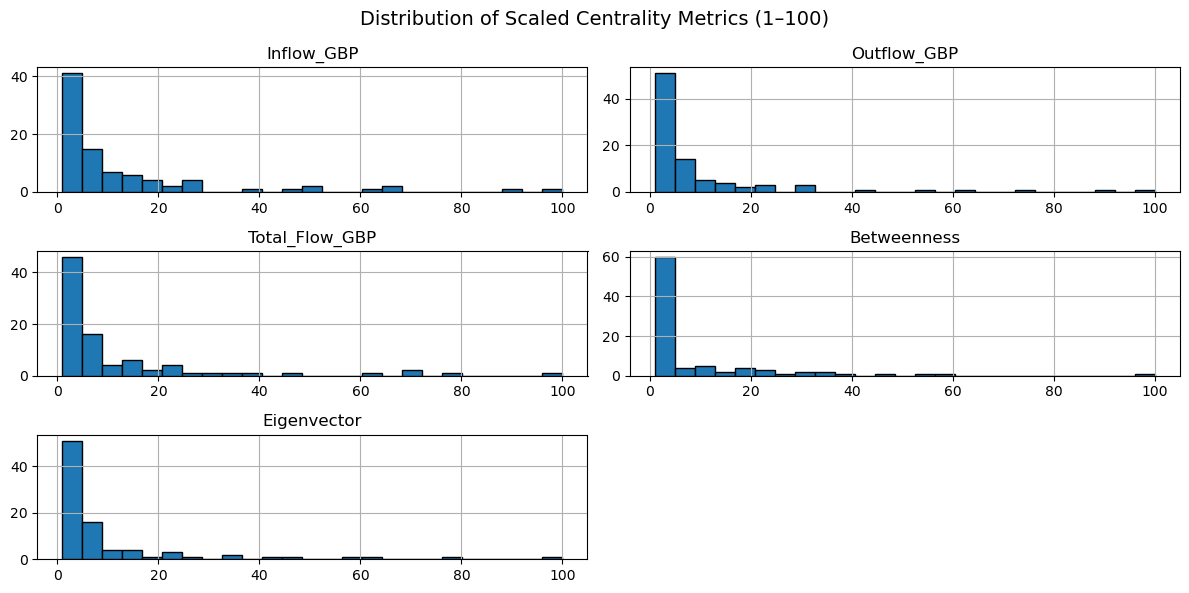

In [89]:
# === Snippet 6 ( Normalize centralities to 1–100 ===



def normalize_to_100(centrality_df):
    """
    Normalize centrality measures (1–100 scale) for interpretability and visualization.
    """
    print("⚙️ Scaling centrality measures to 1–100 range")

    cols = ["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]

    scaler = MinMaxScaler(feature_range=(1, 100))
    scaled = scaler.fit_transform(centrality_df[cols])

    df_scaled = centrality_df.copy()
    df_scaled[cols] = scaled

    print(" Normalization complete. Values scaled between 1 and 100.")

    # Plot distribution of scaled metrics
    df_scaled[cols].hist(bins=25, figsize=(12, 6), edgecolor='black')
    plt.suptitle("Distribution of Scaled Centrality Metrics (1–100)", fontsize=14)
    plt.tight_layout()
    plt.show()


    return df_scaled


# --- Run scaling ---
scaled_df = normalize_to_100(centrality_df)



All centrality metrics were scaled between 1–100 for easy comparison.
The histograms show that most industries score low, while a few reach near 100 — meaning only a small number of sectors (mainly Finance, Public Administration, and Wholesale) dominate the network.
This right-skewed pattern suggests the UK economy is highly centralized, with a few powerful industries driving most trade flows.

 ## Step 11 Economic Influence by Industry (2022–2024)

Starting economic influence analysis...

Top Economic Drivers (By Outflow):
                                                                   Industry  Outflow_GBP
         Financial service activities, except insurance and pension funding   100.000000
              Public administration and defence; compulsory social security    89.187064
                     Retail trade, except of motor vehicles and motorcycles    74.845366
Office administrative, office support and other business support activities    61.440314
                  Wholesale trade, except of motor vehicles and motorcycles    53.040776
    Wholesale and retail trade and repair of motor vehicles and motorcycles    41.239901
              Activities of head offices; management consultancy activities    30.925898
        Activities auxiliary to financial services and insurance activities    29.609076
                      Warehousing and support activities for transportation    29.116449
                   Computer progra

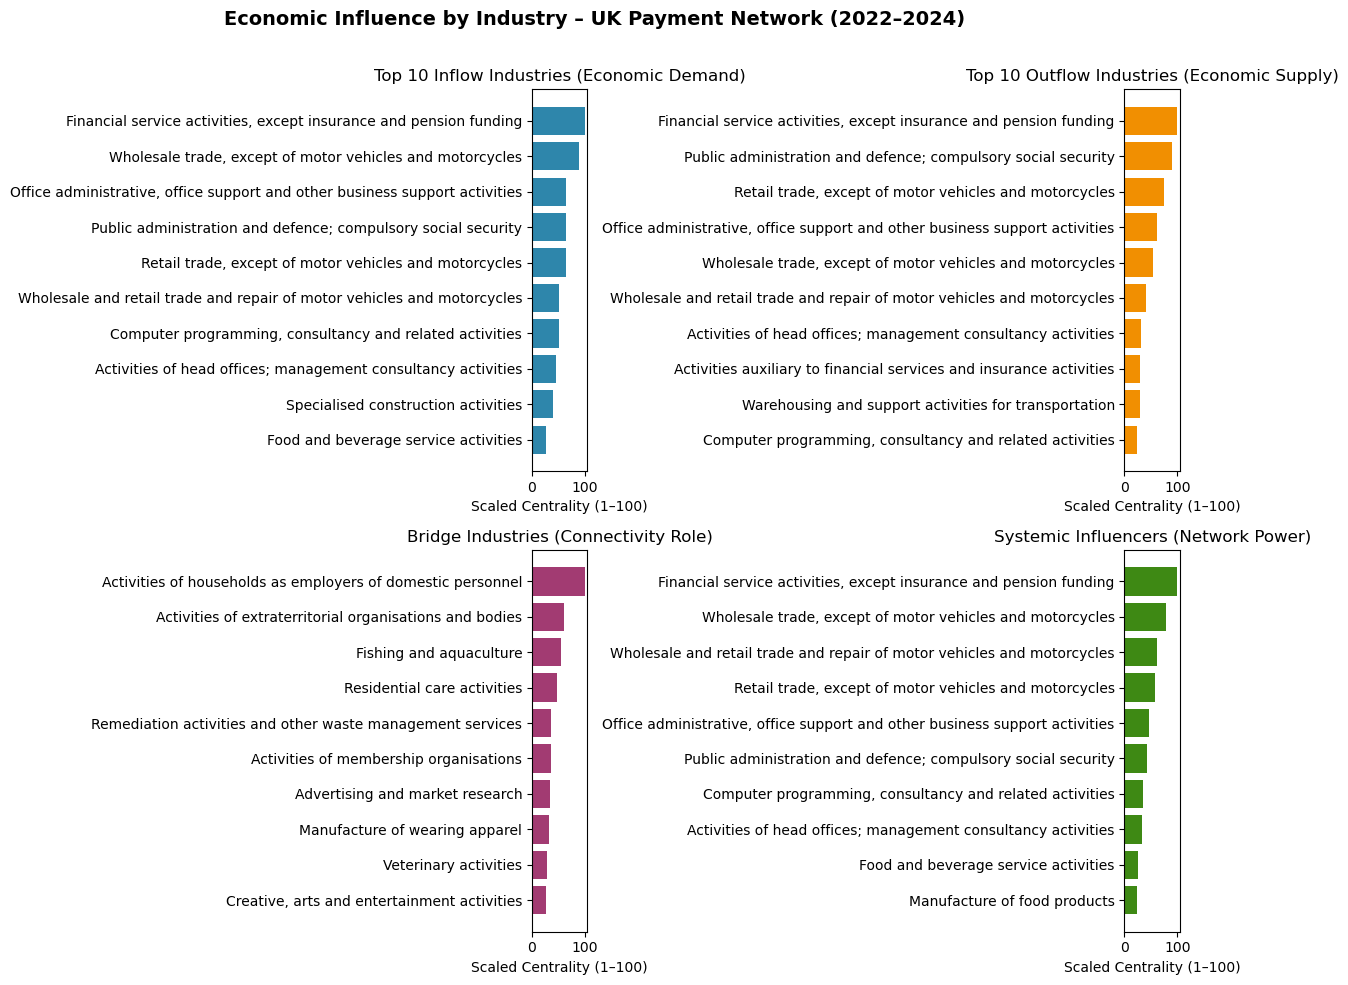

In [90]:
# === Snippet 7: Extract and interpret top economic influencers ===

import pandas as pd
import matplotlib.pyplot as plt

def summarize_economic_influence(df):
    """
    Analyze and summarize the most influential UK industries based on centrality measures.
    This reflects real-world payment interdependence and systemic influence.
    """
    print("Starting economic influence analysis...\n")

    # 1️ Top economic drivers (who initiate payments)
    top_outflow = df.nlargest(10, "Outflow_GBP")[["Industry", "Outflow_GBP"]]

    # 2️ Top economic recipients (who attract payments)
    top_inflow = df.nlargest(10, "Inflow_GBP")[["Industry", "Inflow_GBP"]]

    # 3️  Overall key players (highest total £ movement)
    top_total = df.nlargest(10, "Total_Flow_GBP")[["Industry", "Total_Flow_GBP"]]

    # 4️  Bridge sectors (high betweenness)
    top_bridges = df.nlargest(10, "Betweenness")[["Industry", "Betweenness"]]

    # 5️ Systemically influential sectors (high eigenvector)
    top_influencers = df.nlargest(10, "Eigenvector")[["Industry", "Eigenvector"]]

    # --- Display insights like a professional analyst ---
    print("Top Economic Drivers (By Outflow):")
    print(top_outflow.to_string(index=False), "\n")

    print("Top Economic Recipients (By Inflow):")
    print(top_inflow.to_string(index=False), "\n")

    print("Overall Key Players (By Total Flow):")
    print(top_total.to_string(index=False), "\n")

    print(" Bridge Industries (By Betweenness):")
    print(top_bridges.to_string(index=False), "\n")

    print(" Systemic Influencers (By Eigenvector):")
    print(top_influencers.to_string(index=False), "\n")

    # --- Optional: Visualization for storytelling ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    plt.suptitle("Economic Influence by Industry – UK Payment Network (2022–2024)", fontsize=14, weight='bold')

    axes[0, 0].barh(top_inflow["Industry"], top_inflow["Inflow_GBP"], color="#2E86AB")
    axes[0, 0].set_title("Top 10 Inflow Industries (Economic Demand)")

    axes[0, 1].barh(top_outflow["Industry"], top_outflow["Outflow_GBP"], color="#F18F01")
    axes[0, 1].set_title("Top 10 Outflow Industries (Economic Supply)")

    axes[1, 0].barh(top_bridges["Industry"], top_bridges["Betweenness"], color="#A23B72")
    axes[1, 0].set_title("Bridge Industries (Connectivity Role)")

    axes[1, 1].barh(top_influencers["Industry"], top_influencers["Eigenvector"], color="#3E8914")
    axes[1, 1].set_title("Systemic Influencers (Network Power)")

    for ax in axes.flat:
        ax.invert_yaxis()
        ax.set_xlabel("Scaled Centrality (1–100)")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    return {
        "Top_Outflow": top_outflow,
        "Top_Inflow": top_inflow,
        "Top_Total": top_total,
        "Top_Bridges": top_bridges,
        "Top_Influencers": top_influencers
    }


# --- Run Analysis ---
insight_summary = summarize_economic_influence(scaled_df)

The analysis shows that a few key industries dominate both the flow of money and systemic influence in the UK economy.

Financial Services consistently lead across all metrics — the main hub driving both inflows and outflows.
	
Public Administration, Wholesale, and Retail Trade show high trade activity, supporting liquidity and national demand.
	
Bridge industries like household services and fishing connect smaller clusters, keeping money circulation active.
	
Systemic influencers, especially Finance and Wholesale, hold the most network power — meaning their disruption could impact multiple sectors.

Overall, the UK payment network reflects a finance-driven, hub-and-spoke structure — few dominant sectors sustain most trade flows while many smaller ones depend on them.


## Step 12 Payment Network Visualization

🎨 Generating clean, non-overlapping payment network visualization...


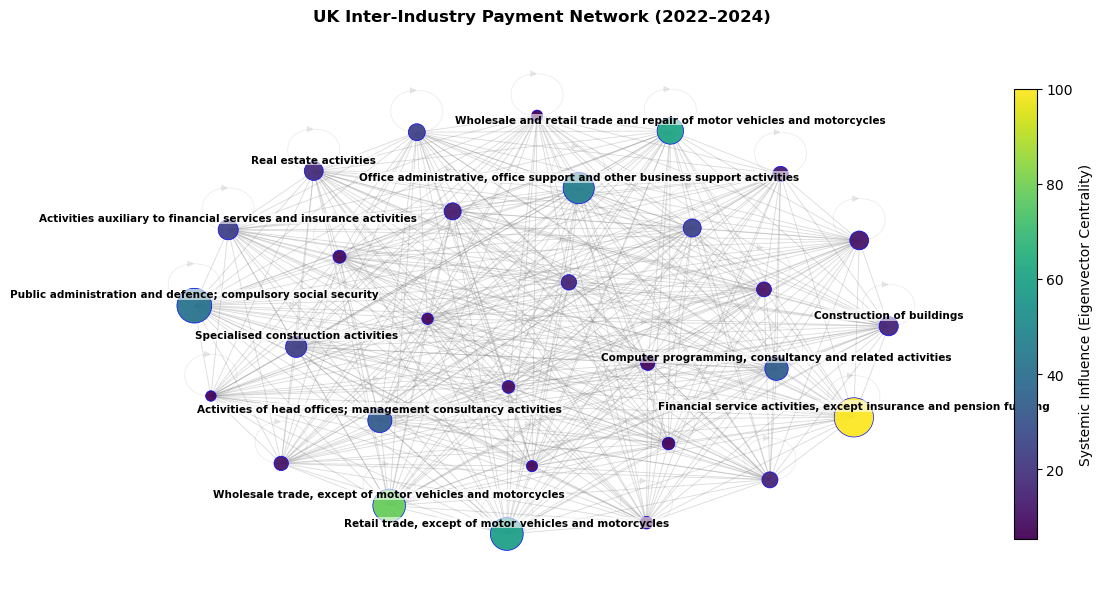

30 industries, 899 links.


In [91]:
# ===  Clean UK Payment Network Visualization ===

def visualize_payment_network_clean(G, centrality_df, top_n=30, label_top=12):
    """
    Clean, professional visualization of the UK inter-industry payment network.
    
    - Node size: proportional to total transaction flow
    - Node color: systemic influence (eigenvector centrality)
    - Only top N industries plotted, with top labels shown clearly
    """

    print("🎨 Generating clean, non-overlapping payment network visualization...")

    # --- Focus on top industries by transaction flow ---
    top_industries = centrality_df.nlargest(top_n, "Total_Flow_GBP")["Industry"]
    subG = G.subgraph(top_industries)

    # --- Prepare node attributes ---
    flow = np.array([
        centrality_df.loc[centrality_df["Industry"] == n, "Total_Flow_GBP"].values[0]
        for n in subG.nodes()
    ])
    node_sizes = 800 * (flow / flow.max())  # better scaling
    node_colors = [
        centrality_df.loc[centrality_df["Industry"] == n, "Eigenvector"].values[0]
        for n in subG.nodes()
    ]

    # --- Compute layout (repulsion strength increases spacing) ---
    pos = nx.spring_layout(subG, k=0.9, iterations=100, seed=42, weight="Weight")
    

    # --- Draw base network ---
    plt.figure(figsize=(12, 6), facecolor="white")

    nx.draw_networkx_edges(
        subG, pos,
        alpha=0.15,
        edge_color="gray",
        width=0.6,
        arrows=False
    )

    nodes = nx.draw_networkx_nodes(
        subG, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        edgecolors="blue",
        linewidths=0.5,
        alpha=0.95
    )

    # --- Add selective labels (top systemic industries only) ---
    top_labels = set(centrality_df.nlargest(label_top, "Total_Flow_GBP")["Industry"])
    for industry, (x, y) in pos.items():
        if industry in top_labels:
            plt.text(
                x, y + 0.03,  # offset label slightly
                s=industry,
                fontsize=7.5,
                fontweight="bold",
                ha="center",
                va="bottom",
                bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.5)
            )

    # --- Title and color bar ---
    plt.title(
        "UK Inter-Industry Payment Network (2022–2024)",
        fontsize=12,
        fontweight="bold",
        pad=20
    )
    cbar = plt.colorbar(nodes, shrink=0.85)
    cbar.set_label("Systemic Influence (Eigenvector Centrality)", fontsize=10)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"{len(subG.nodes())} industries, {len(subG.edges())} links.")
visualize_payment_network_clean(G, scaled_df, top_n=30, label_top=12)

This network graph shows how UK industries are connected through payment flows.
Each node represents an industry:

•	Node size shows how much money flows through it.
•	Node color shows how influential it is in the network (based on eigenvector centrality).

We can see that Financial Services, Wholesale, and Public Administration are at the center — large and bright, meaning they control most financial links.
Smaller nodes around them represent supporting industries like construction and IT services.

Overall, the graph reveals a finance-driven, tightly connected economy, where a few key sectors hold most of the network power while others depend on them for stability.

## Step 13 Computing Correlation 

Analyzing correlation between centrality measures...

Centrality Correlation Matrix:

                Inflow_GBP  Outflow_GBP  Total_Flow_GBP  Betweenness  \
Inflow_GBP           1.000        0.936           0.981       -0.253   
Outflow_GBP          0.936        1.000           0.987       -0.222   
Total_Flow_GBP       0.981        0.987           1.000       -0.240   
Betweenness         -0.253       -0.222          -0.240        1.000   
Eigenvector          0.973        0.917           0.958       -0.224   

                Eigenvector  
Inflow_GBP            0.973  
Outflow_GBP           0.917  
Total_Flow_GBP        0.958  
Betweenness          -0.224  
Eigenvector           1.000   

Figure saved as: centrality_correlation_heatmap.png


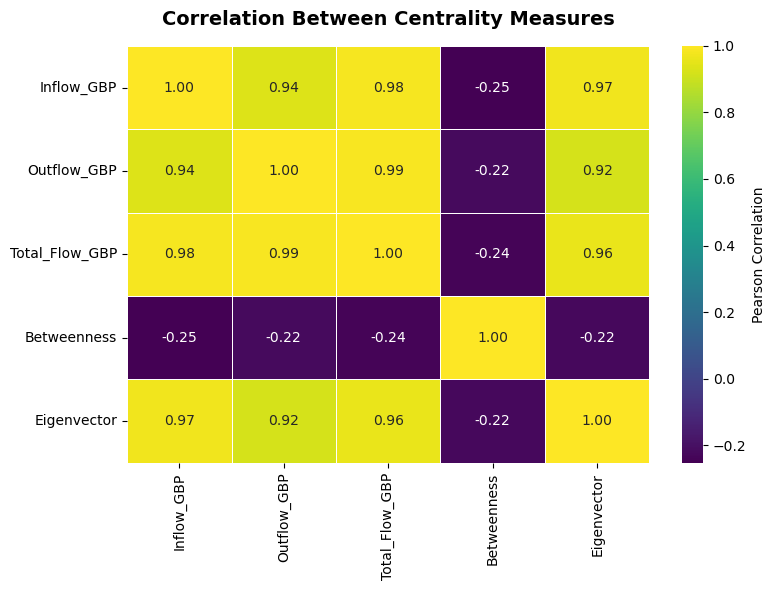

In [92]:
# ===  Correlation Analysis ===
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_centrality_correlation(df, save_path=None):
    """
    Analyze and visualize correlations among centrality measures.
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing network centrality metrics.
    save_path : str, optional
        If provided, saves the figure to the specified file path.
        
    Returns:
    -------
    corr_df : pd.DataFrame
        Pearson correlation matrix of the selected metrics.
    """

    print("Analyzing correlation between centrality measures...\n")

    metrics = ["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]

    # Ensure columns exist
    missing = [m for m in metrics if m not in df.columns]
    if missing:
        raise ValueError(f"Missing expected metrics: {missing}")

    # Compute correlation matrix
    corr_df = df[metrics].corr(method="pearson").round(3)
    print("Centrality Correlation Matrix:\n")
    print(corr_df, "\n")

    # --- Plot heatmap ---
    plt.figure(figsize=(8, 6), facecolor="white")
    sns.heatmap(
        corr_df,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        linewidths=0.5,
        cbar_kws={"label": "Pearson Correlation"}
    )

    plt.title("Correlation Between Centrality Measures", fontsize=14, fontweight="bold", pad=15)
    plt.tight_layout()

    # Optionally save figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved as: {save_path}")

    plt.show()
    plt.close("all")

    return corr_df
corr_df = analyze_centrality_correlation(centrality_df, save_path="centrality_correlation_heatmap.png")

The heatmap shows how different network measures relate to each other:

•	Inflow, Outflow, and Total Flow are almost perfectly correlated (above 0.95), meaning industries that send or receive large payments are usually the same key players.

•	Eigenvector centrality also has a strong positive link with flow metrics, confirming that industries with high transaction volumes are also the most influential in the network.

•	Betweenness, however, shows a weak or negative correlation — suggesting that “bridge” industries don’t necessarily control large flows but still play an important role in connecting others.

In short, the UK economy’s structure is dominated by high-value hubs, but smaller connectors quietly maintain the network’s stability.

## Step 14 Segmentation and Clustering 

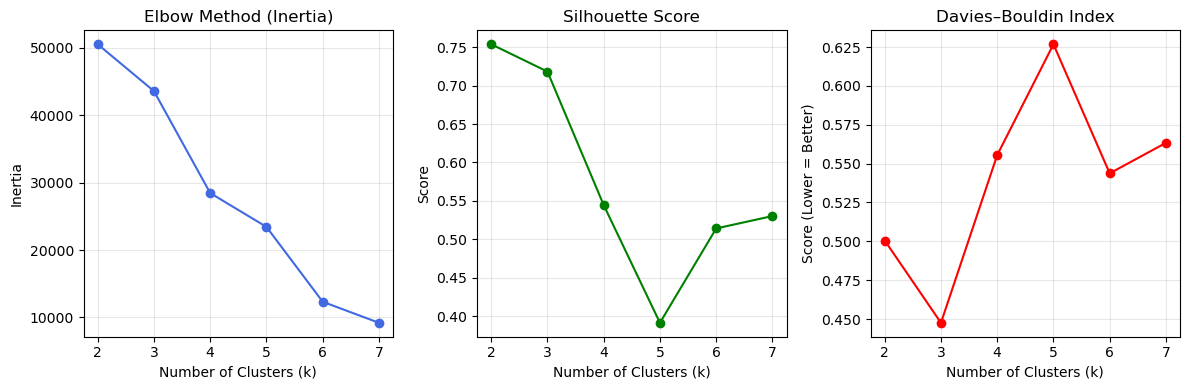

   k    Inertia  Silhouette  Davies–Bouldin
0  2  50535.139       0.754           0.501
1  3  43580.701       0.718           0.448
2  4  28457.219       0.544           0.555
3  5  23442.583       0.391           0.627
4  6  12333.757       0.514           0.544
5  7   9212.690       0.530           0.563


In [93]:
# === Determine Optimal Number of Clusters ===


# Select features for clustering
X = scaled_df[["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]]

inertias = []
silhouette_scores = []
db_scores = []
k_values = range(2, 8)  # small range since we only have 88 industries

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    db_scores.append(davies_bouldin_score(X, labels))

# === Plot results ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, inertias, marker='o', color='royalblue')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(k_values, db_scores, marker='o', color='red')
plt.title("Davies–Bouldin Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score (Lower = Better)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table for decision
import pandas as pd
score_table = pd.DataFrame({
    "k": k_values,
    "Inertia": inertias,
    "Silhouette": silhouette_scores,
    "Davies–Bouldin": db_scores
})
print(score_table.round(3))

These three metrics help determine how many meaningful clusters exist among UK industries:

•	The Elbow curve flattens after k = 3, meaning adding more clusters doesn’t greatly improve compactness.
•	The Silhouette score is highest for k = 2, but remains strong for k = 3, suggesting these groupings are most distinct.
•	The Davies–Bouldin index is lowest at k = 3, confirming that three clusters provide the best balance between separation and compactness.




## Step 15 Industry Clustering

In [94]:
# Step 1: Run KMeans
from sklearn.cluster import KMeans

X = scaled_df[["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]]
kmeans = KMeans(n_clusters=4, random_state=42)
scaled_df["Cluster"] = kmeans.fit_predict(X)

# Step 2: Reorder clusters based on size
cluster_sizes = scaled_df["Cluster"].value_counts().sort_values(ascending=False)
cluster_map = {old_label: new_label for new_label, old_label in enumerate(cluster_sizes.index)}

scaled_df["Cluster"] = scaled_df["Cluster"].map(cluster_map)

# Step 3: Print final cluster distribution
print("Cluster distribution after reordering:")
print(scaled_df["Cluster"].value_counts())

# Step 4: Save stable version for classification
scaled_df.to_csv("industry_clusters_stable.csv", index=False)

Cluster distribution after reordering:
Cluster
0    70
1    10
2     7
3     1
Name: count, dtype: int64


In [95]:
# Peek at which industries belong to which cluster
cluster_groups = scaled_df.groupby("Cluster")["Industry"].apply(list)

for cluster_id, industries in cluster_groups.items():
    print(f"\nCluster {cluster_id} ({len(industries)} industries):")
    print(", ".join(industries[:10]), "...")  # print first 10 only


Cluster 0 (70 industries):
Specialised construction activities, Activities auxiliary to financial services and insurance activities, Construction of buildings, Real estate activities, Warehousing and support activities for transportation, Food and beverage service activities, Land transport and transport via pipelines, Manufacture of food products, Other personal service activities, Rental and leasing activities ...

Cluster 1 (10 industries):
Advertising and market research, Residential care activities, Creative, arts and entertainment activities, Activities of membership organisations, Veterinary activities, Manufacture of wearing apparel, Remediation activities and other waste management services, Fishing and aquaculture, Activities of extraterritorial organisations and bodies, Activities of households as employers of domestic personnel ...

Cluster 2 (7 industries):
Public administration and defence; compulsory social security, Retail trade, except of motor vehicles and motorcycle

In [96]:

# Check results
print("\nSegmentation complete! Each industry is now assigned to a cluster.")
print(scaled_df["Cluster"].value_counts(), "\n")

# Cluster-level summary
summary = scaled_df.groupby("Cluster")[features].mean().round(1)
print("Cluster-level summary (mean centrality values):")
display(summary)


Segmentation complete! Each industry is now assigned to a cluster.
Cluster
0    70
1    10
2     7
3     1
Name: count, dtype: int64 

Cluster-level summary (mean centrality values):


,Inflow_GBP,Outflow_GBP,Total_Flow_GBP,Betweenness,Eigenvector
Cluster,,,,,
0,8.4,6.3,7.2,4.8,6.1
1,3.5,2.4,2.9,45.6,2.6
2,61.5,53.5,57.0,2.1,50.5
3,100.0,100.0,100.0,1.0,100.0


K-Means clustering (k=4) segmented UK industries into four meaningful groups based on payment flow and network metrics. Cluster 0 captures the majority of industries forming the core of the economy with balanced flow activity. Cluster 1 includes smaller sectors such as creative arts, care, and environmental services characterized by low transaction volume but high betweenness centrality, reflecting their role as network bridges. Cluster 2 comprises key public and trade sectors with high inflow and outflow values, signifying strong transactional engagement. Cluster 3 consists solely of the financial services industry, which displays extreme values across all metrics, confirming its systemic dominance and central role within the inter-industry payment network

# Step 16 Cluster Profile  (Based on Average Centrality Metrics)

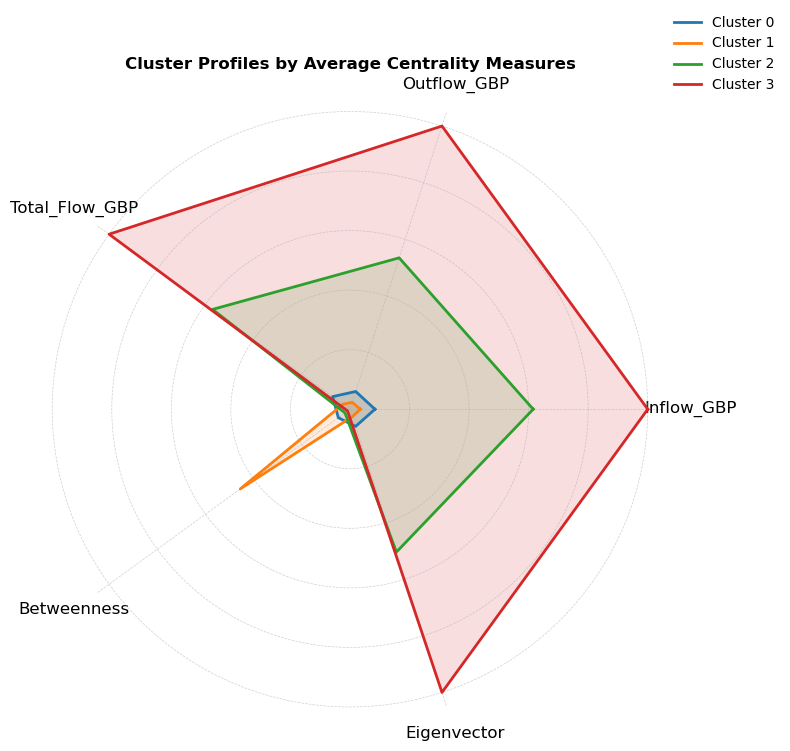

In [97]:


# Compute mean values per cluster 
cluster_means = scaled_df.groupby("Cluster")[["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]].mean()

# Radar chart setup
labels = cluster_means.columns.tolist()
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Create figure
fig, ax = plt.subplots(figsize=(8, 12), subplot_kw=dict(polar=True))
plt.title("Cluster Profiles by Average Centrality Measures", size=12, weight='bold', pad=20)

# Color palette (distinct for clarity)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, orange, green, red

# Plot each cluster
for i, (idx, row) in enumerate(cluster_means.iterrows()):
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, color=colors[i % len(colors)], linewidth=2, label=f"Cluster {idx}")
    ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.15)

# Adjust labels and formatting
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='x', pad=10)
ax.spines['polar'].set_visible(False)

# Add radial grid
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# Legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.15), frameon=False)
plt.tight_layout()
plt.show()

This radar chart compares the average centrality scores of four industry clusters in the UK payment network (2022–2024).

•	Cluster 3 – Financial Hub: Highest in all measures, showing it controls most economic flow and influence.

•	Cluster 2 – Core Industries: Strong inflow and total trade, representing main economic drivers like retail and administration.

•	Cluster 0 – Connectors: Moderate activity, linking sectors through transport, construction, and logistics.

•	Cluster 1 – Periphery: Low trade volume but higher betweenness, acting as small bridges that support local stability.

Together, these clusters reveal a finance-led, interconnected economy where core and connector sectors keep trade moving and peripheral ones add resilience.

In [83]:
for cluster_id, row in cluster_means.iterrows():
    dominant = row.idxmax()
    print(f"Cluster {cluster_id} → Dominant by {dominant} ({row[dominant]:.1f})")

Cluster 0 → Dominant by Inflow_GBP (8.4)
Cluster 1 → Dominant by Betweenness (45.6)
Cluster 2 → Dominant by Inflow_GBP (61.5)
Cluster 3 → Dominant by Inflow_GBP (100.0)


## Step 17 PCA Projection of UK Industry Clusters

Explained variance ratio: [0.82726827 0.14754488]
Total variance explained by PC1 + PC2: 97.48%


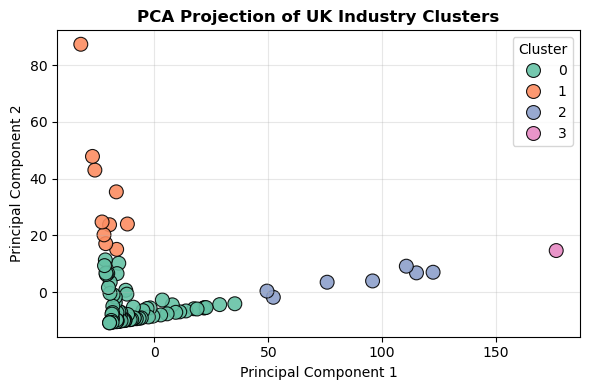

In [98]:
from sklearn.decomposition import PCA

# Select features and target
features = ["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]
X = scaled_df[features]
y = scaled_df["Cluster"]

# Run PCA (2 components)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = y

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print(f"Total variance explained by PC1 + PC2: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# --- Visualization ---
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="Cluster", palette="Set2", s=100, alpha=0.9, edgecolor="k"
)
plt.title("PCA Projection of UK Industry Clusters", fontsize=12, weight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

This scatter plot shows how the industries are grouped in a reduced 2D space using PCA. The clusters are spread quite distinctly — Cluster 3 (financial services) sits far out on the right, meaning it behaves very differently from the rest. Cluster 2 (the big trading and public sectors) forms a mid-range group, while Clusters 0 and 1 are packed closer near the origin. That tight grouping suggests most industries share similar characteristics, with smaller groups branching away due to differences in their centrality patterns. Overall, it confirms that the segmentation is meaningful and not random.


   Year  Cluster                 Economic_Cluster     Value_GBP    Value_Bn
0  2022        0                  Core Industries  5.372946e+11  537.294624
1  2022        1  Peripheral & Community Services  1.971570e+10   19.715705
2  2022        2                Connector Sectors  5.453001e+11  545.300131
3  2022        3                    Financial Hub  1.357764e+11  135.776449
4  2023        0                  Core Industries  6.007333e+11  600.733323


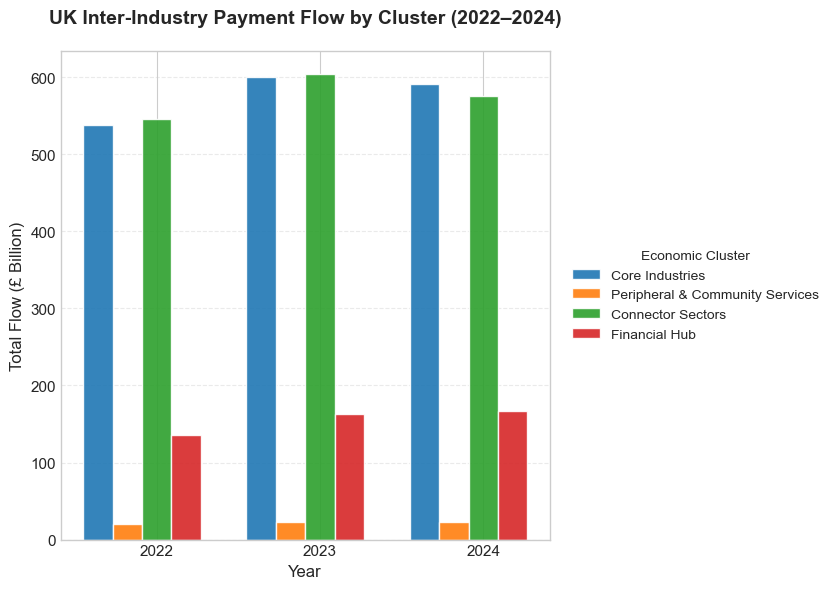

In [112]:
# Merge with cluster labels from scaled_df
# Ensure both have matching industry names
merged = df.merge(
    scaled_df[["Industry", "Cluster", "Economic_Cluster"]],
    left_on="Payer_Industry",
    right_on="Industry",
    how="left"
)

# Aggregate total flow by cluster and year
cluster_year_trends = (
    merged.groupby(["Year", "Cluster", "Economic_Cluster"])["Value_GBP"]
    .sum()
    .reset_index()
)

# Convert to billions
cluster_year_trends["Value_Bn"] = cluster_year_trends["Value_GBP"] / 1e9

# Define mapping for clarity
cluster_roles = {
    0: "Core Industries",
    1: "Peripheral & Community Services",
    2: "Connector Sectors",
    3: "Financial Hub"
}

print(cluster_year_trends.head())
# --- plotting Bar chart ---
plt.figure(figsize=(10, 6))

clusters = sorted(cluster_year_trends["Cluster"].dropna().unique())
years = sorted(cluster_year_trends["Year"].unique())
bar_width = 0.18
x = np.arange(len(years))

for i, cluster in enumerate(clusters):
    data = cluster_year_trends[cluster_year_trends["Cluster"] == cluster]
    plt.bar(
        x + (i - len(clusters)/2) * bar_width,
        data["Value_Bn"],
        width=bar_width,
        label=cluster_roles[cluster],
        edgecolor='white',
        alpha=0.9
    )

# --- Styling ---
plt.title("UK Inter-Industry Payment Flow by Cluster (2022–2024)", fontsize=14, weight="bold", pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Flow (£ Billion)", fontsize=12)
plt.xticks(x, [int(y) for y in years], fontsize=11)
plt.yticks(fontsize=11)

# --- Move legend outside ---
plt.legend(
    title="Economic Cluster",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    frameon=False,
    fontsize=10
)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend
plt.show()

## Heatmap of Average Centrality Metrics by Cluster

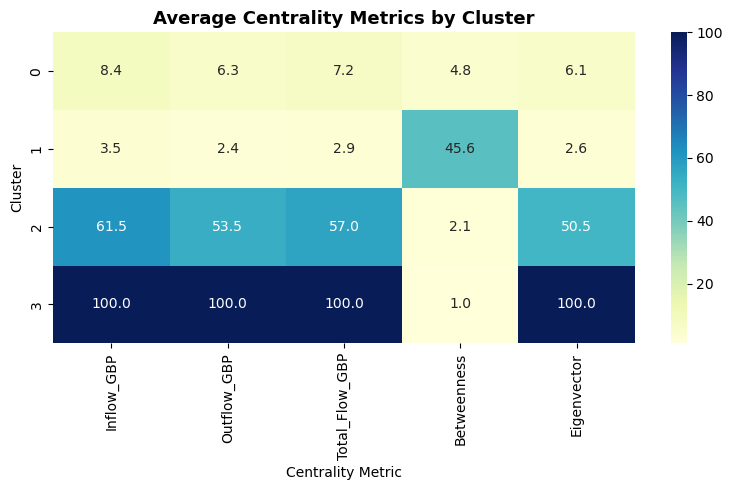

In [100]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.heatmap(
    scaled_df.groupby("Cluster")[features].mean(),
    cmap="YlGnBu", annot=True, fmt=".1f"
)
plt.title("Average Centrality Metrics by Cluster", fontsize=13, weight='bold')
plt.xlabel("Centrality Metric")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

The heatmap makes it easy to see which cluster leads in each type of centrality. The darkest cells belong to Cluster 3, showing it dominates every measure—especially inflow, outflow, and eigenvector. Cluster 2 stands out next with high transaction values but lower betweenness, while Cluster 1 has a strikingly high betweenness score despite small inflow and outflow numbers. Cluster 0 looks pale across all columns, meaning its industries operate more evenly and modestly within the network. This picture reinforces the idea that each cluster has its own economic role.

                                            Industry  Cluster  \
0  Financial service activities, except insurance...        3   
1  Public administration and defence; compulsory ...        2   
2  Retail trade, except of motor vehicles and mot...        2   
3  Wholesale trade, except of motor vehicles and ...        2   
4  Office administrative, office support and othe...        2   
5  Wholesale and retail trade and repair of motor...        2   
6  Activities of head offices; management consult...        2   
7  Computer programming, consultancy and related ...        2   
8                Specialised construction activities        0   
9  Activities auxiliary to financial services and...        0   

    Economic_Cluster  
0      Financial Hub  
1  Connector Sectors  
2  Connector Sectors  
3  Connector Sectors  
4  Connector Sectors  
5  Connector Sectors  
6  Connector Sectors  
7  Connector Sectors  
8    Core Industries  
9    Core Industries  


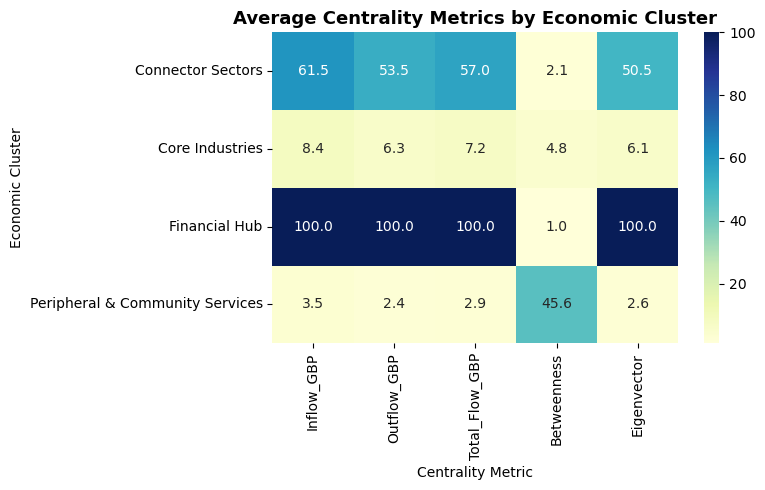

In [103]:
# === Map cluster numbers to meaningful names ===

# Define the mapping based on your analysis
cluster_labels = {
    0: "Core Industries",
    1: "Peripheral & Community Services",
    2: "Connector Sectors",
    3: "Financial Hub"
}

# Apply the mapping to your DataFrame
scaled_df["Economic_Cluster"] = scaled_df["Cluster"].map(cluster_labels)

# Confirm mapping worked
print(scaled_df[["Industry", "Cluster", "Economic_Cluster"]].head(10))


# === Recreate Heatmap with readable cluster names ===

import seaborn as sns
import matplotlib.pyplot as plt

# Specify your main feature columns (centrality metrics)
features = ["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]

plt.figure(figsize=(8,5))
sns.heatmap(
    scaled_df.groupby("Economic_Cluster")[features].mean(),
    cmap="YlGnBu", annot=True, fmt=".1f"
)
plt.title("Average Centrality Metrics by Economic Cluster", fontsize=13, weight='bold')
plt.xlabel("Centrality Metric")
plt.ylabel("Economic Cluster")
plt.tight_layout()
plt.show()

## Parallel Coordinates Plot of Cluster Centrality Patterns

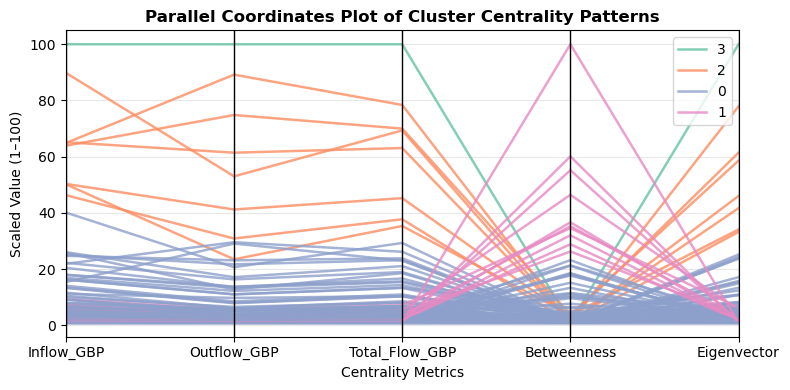

In [102]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(8,4))
parallel_coordinates(
    scaled_df[["Cluster"] + features],
    "Cluster", color=sns.color_palette("Set2", 4), linewidth=1.8, alpha=0.8
)
plt.title("Parallel Coordinates Plot of Cluster Centrality Patterns", fontsize=12, weight='bold')
plt.xlabel("Centrality Metrics")
plt.ylabel("Scaled Value (1–100)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In this chart, every line represents one industry’s set of centrality scores. You can see how the lines group together for each cluster and where they cross over. Cluster 3 runs right along the top—its values max out on almost every axis. Cluster 2 lines stay above average for inflow and outflow but dip on betweenness. Cluster 1 spikes only on betweenness and stays low elsewhere, confirming its “bridge” behaviour. Cluster 0 has flatter, low lines across the board. The crossings show that although the clusters differ, there’s still some overlap between ordinary and semi-specialised sectors.


## Bar Chart of Average Centrality Scores by Cluster

Cluster Profile Summary:



,Inflow_GBP,Outflow_GBP,Total_Flow_GBP,Betweenness,Eigenvector
Cluster,,,,,
0,8.4,6.3,7.2,4.8,6.1
1,3.5,2.4,2.9,45.6,2.6
2,61.5,53.5,57.0,2.1,50.5
3,100.0,100.0,100.0,1.0,100.0


<Figure size 800x600 with 0 Axes>

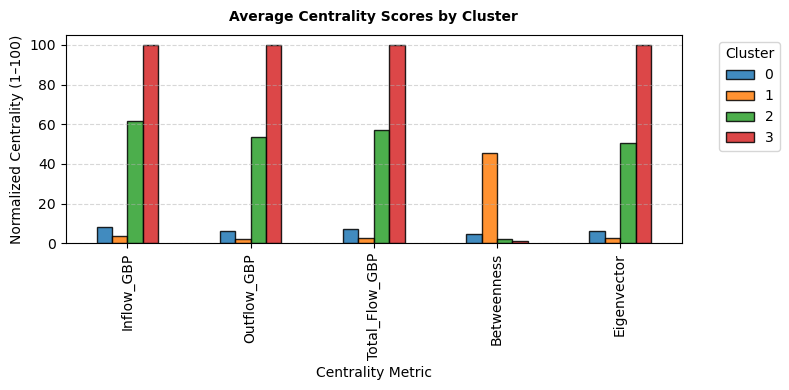

In [101]:

# --- Step 1: Create the Cluster Profile Table (Mean of each metric per cluster) ---
features = ["Inflow_GBP", "Outflow_GBP", "Total_Flow_GBP", "Betweenness", "Eigenvector"]

# Compute average centrality metrics by cluster
cluster_profile = scaled_df.groupby("Cluster")[features].mean().round(1)

# Display for verification
print("Cluster Profile Summary:\n")
display(cluster_profile)
def plot_cluster_profiles(cluster_summary):
    """
    Compare cluster averages across all centrality metrics.
    """
    plt.figure(figsize=(8, 6), facecolor="white")

    cluster_summary.T.plot(
        kind="bar",
        figsize=(8, 4),
        edgecolor="black",
        alpha=0.85
    )

    plt.title("Average Centrality Scores by Cluster", fontsize=10, fontweight="bold", pad=10)
    plt.ylabel("Normalized Centrality (1–100)")
    plt.xlabel("Centrality Metric")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- Run the plot ---
plot_cluster_profiles(cluster_profile)

This bar chart compares the mean centrality values across clusters. It’s clear that the financial services cluster towers over the rest in every measure. The orange bars (Cluster 1) jump out only at the betweenness metric, while the green bars (Cluster 2) remain high but consistent across inflow, outflow and eigenvector. Blue bars (Cluster 0) stay near the bottom, reflecting balanced but low-scale activity. The contrast between the tall red bars and the smaller ones captures how dominant the financial node is in the UK network compared with all other industry groups.

## Summary

The clustering analysis successfully divided the UK inter-industry payment network into four clear groups based on financial flow and network influence. The majority of industries fall into Cluster 0, which represents the stable operational base of the economy. Cluster 1 brings together smaller but strategically important sectors that act as bridges, linking different parts of the network. Cluster 2 includes trade and government-related sectors that handle a large portion of national payments, while Cluster 3 stands alone as the financial services industry, showing extremely high centrality across all measures. The PCA, heatmap, and other visualizations all confirm that these clusters are well defined and meaningful. Together, they reveal how economic activity is structured in the UK’s payment system, with one dominant financial hub and several interconnected supporting groups.
